In [1]:
import numpy as np
import matplotlib.pyplot as plt
hbar_eVs = 6.58212E-16 # Planck's constant [eV*s]
c = 2.998E+10 # speed of light [cm/s]

## Import coupled dipole code. Can be found at https://github.com/claireannewest/coupled_dipoles.git
## Put your own path here
import sys
sys.path.insert(1, '/Users/clairewest/werk/research/my_codes/coupled_dipoles')

from coupled_dipole_model import Sphere_Polarizability
from coupled_dipole_model import CrossSections

### Genetic Algorithm Equations

In [2]:
def calc_analytics(w_all, gap, pop_size):
    """This function plots the individual particle and total cross-sections.
    
    drive -- polarization of light (e.g. x polarized = np.array([1, 0, 0]) )
    """
    num_part_per_struct = 2
    w_all = w_all/hbar_eVs
    num_freq = len(w_all)
    num_gap = len(gap)
    Pabs_tot = np.zeros((pop_size[0], num_part_per_struct))

    # loop through frequencies + gaps (sad face)
    for i in range(0, pop_size[0]):
        which_gap = gap[i]
        which_freq = w_all[i]

        def_centers = np.zeros((1, 1, 1, num_part_per_struct, 3)) 
        def_all_radii = np.zeros((1, 1, 1, num_part_per_struct)) 
        def_all_radii[0,0,0,0] = 20*1.E-7
        def_all_radii[0,0,0,1] = 10*1.E-7

        which_radii_0 = def_all_radii[0, 0, 0, 0]*1.E7
        def_centers[0,0, :, 0,:] = np.array([ 0, 0, -which_radii_0-which_gap/2 ])*1.E-7
        which_radii_1 = def_all_radii[0, 0, 0, 1]*1.E7
        def_centers[0,0, :, 1,:] = np.array([ 0, 0, which_radii_1+which_gap/2 ])*1.E-7    

        calc_dips = CrossSections(centers=def_centers, 
                                       all_radii=def_all_radii,
                                       w=which_freq,
                                       num=num_part_per_struct, 
                                       n=1.0, 
                                       wp=8.959/hbar_eVs, 
                                       eps_inf=9.695, 
                                       gam_drude=0.073/hbar_eVs)    
        _, Pabs = calc_dips.cross_sects(drive=np.array([0,0,1]))
        Pabs_tot[i,0] = Pabs[0,0,0,0]
        Pabs_tot[i,1] = Pabs[0,0,0,1]
    return Pabs_tot 



In [3]:
def cal_pop_fitness(pop):
    # Calculating the fitness value of each solution in the current population.
    # Wavelength where abs_1 - abs_2 is max and vice versa
    Pabs = calc_analytics(w_all=pop[:,0], gap=pop[:,1], pop_size = pop.shape)
    fitness = Pabs[:,1] - Pabs[:,0]
    return fitness


In [4]:
def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
#     print('pop', pop)
#     print('parents', parents)
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring


def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = np.random.uniform(-.008, .008, 1)
        mut_idx = 0
        offspring_crossover[idx, mut_idx] = offspring_crossover[idx, mut_idx] + random_value
    return offspring_crossover


### Defining initial population

In [5]:
num_weights = 2 # we'll guess lambda and gap size
sol_per_pop = 20 

# The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
pop_size = (sol_per_pop, num_weights) 

# Creating the initial population.
initial_population = np.zeros(pop_size)
## Frequency
initial_population[:,0] = np.random.uniform(low=2.2, high=2.8, size=(sol_per_pop))
## Gap                   
initial_population[:,1] = np.random.uniform(low=1.0, high=10., size=(sol_per_pop))

# print(initial_population)
# print('Initial fit', cal_pop_fitness(pop=initial_population))

In [6]:
num_generations = 80
num_parents_mating = 10
new_population = initial_population

init_fitness = cal_pop_fitness(initial_population)
init_match_idx = np.where(init_fitness == np.max(init_fitness))
print("Init solution : ", initial_population[init_match_idx, :][0][0], 'with', np.round(init_fitness[init_match_idx][0], 4))

for generation in range(num_generations):
    # Measuring the fitness of each chromosome in the population.
    # i.e. calculates T(lambda). The greater the T, the better the answer.
    fitness = cal_pop_fitness(new_population)
    
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                       num_parents_mating)
    
    
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                        offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation. (It's currently hitting the 4th gene)
    offspring_mutation = mutation(offspring_crossover)
    
    # Creating the new population based on the parents and offspring.
    # We keep the parents just in case all the randomly generated offspring are worse. This prevents us from going backwards.
    # 4 parents, 4 offspring
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
#     print('new_pop', new_population)
    # The best result in the current iteration.
#     print("Best result : ", np.max(cal_pop_fitness(new_population)))

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness = cal_pop_fitness(pop=new_population)

# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))
print("Best solution : ", new_population[best_match_idx, :][0][0], 'with', np.round(fitness[best_match_idx][0], 4))


Init solution :  [2.58863887 4.00696548] with 0.0003
Best solution :  [2.61415966 4.00696548] with 0.0007


GA solution 2.614 eV 4.007 nm
Actual solution 2.616 0.00071


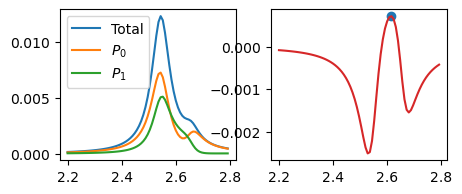

In [7]:
w = np.arange(2.2, 2.8, .008)

pred_wave, pred_gap = new_population[best_match_idx, :][0][0]

gap_all = np.zeros(len(w))+pred_gap

Pabs = calc_analytics(w_all=w, gap=gap_all, pop_size=(len(w),0))


fig = plt.figure(figsize=(5.,2.), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1, 2, 1)

# print(Pabs.shape)
ax1.plot(w, Pabs[:,1]+Pabs[:,0],label='Total')
ax1.plot(w, Pabs[:,0],label='$P_0$')
ax1.plot(w, Pabs[:,1],label='$P_1$')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(w, Pabs[:,1]-Pabs[:,0],label='P_1 - P_0',color="tab:red")
ax2.scatter(pred_wave, fitness[best_match_idx][0])


idx = np.where(Pabs[:,1]-Pabs[:,0] == max(Pabs[:,1]-Pabs[:,0]))

print('GA solution', np.round(pred_wave,3), 'eV',  np.round(pred_gap,3), 'nm')
print('Actual solution', np.round(w[idx][0],3), np.round(max(Pabs[:,1]-Pabs[:,0]), 5))